# Import Libraries

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math

import os

# Read Datafile

In [2]:
data = pd.read_csv('South_Korea_airport_toy_example.csv')
data

,Name,Type,IATA,ICAO,Longitude (deg),Latitude (deg)
0,Incheon,International,ICN,RKSI,126.4498,37.4465
1,Jeju,International,CJU,RKPC,126.4928,33.5111
2,Cheongju,International,CJJ,RKTU,127.4989,36.7164
3,Yangyang,International,YNY,RKNY,128.6689,38.0611
4,Pohang,Domestic,KPO,RKTH,129.4205,35.9879
5,Gimhae,International,PUS,RKPK,128.9381,35.1794


# Define Haversine

In [3]:
from math import radians, sin, cos, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    return 2 * 6371 * asin(sqrt(a))

# Define Coordinates and Edges 

In [4]:
#polygon list
polygon = [(128.7, 36.6), (128.7, 37.6), (129.3, 37.6), (129.3, 36.6)]

#add the first element to the end for polygon plot
polygon = polygon + [polygon[0]]

#create a dictionary of edges (duplicates included)
airport_dict = {0: [1,2,3],
                1: [0,2,5],
                2: [0,1,4,5],
                3: [0,4],
                4: [2,3,5],
                5: [1,2,4]}

#remove duplicates in 'airport_dict' to create a edge list (x,y)
airport_edge = []
for k,v in airport_dict.items():
    for vi in v:
        if (k,vi) not in airport_edge and (vi, k) not in airport_edge:
            airport_edge.append((k,vi))

In [5]:
xi = [xi for xi,xj in airport_edge] #list of xi nodes
xj = [xj for xi,xj in airport_edge] #list of xj nodes

# Plot Graph

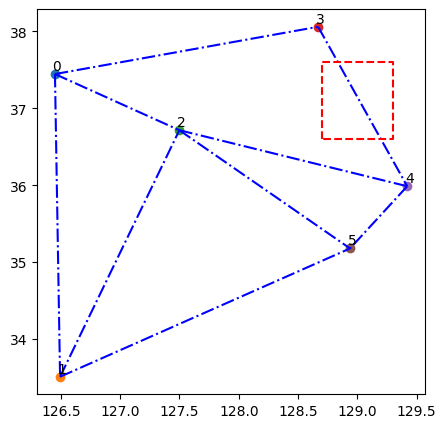

In [76]:
plt.figure(figsize = (5,5))
for n1, n2 in zip(xi,xj):
    plt.plot([data.iloc[n1, -2],data.iloc[n2, -2]], [data.iloc[n1,-1],data.iloc[n2,-1]], '-.', c = 'blue')

x_shift = -0.02 #longitudinal shift of annotations
y_shift = 0.05 #latitudinal shift of annotations

#scatter plot of cities with annotations
for i in range(len(data.index)):
    x_coord = data.iloc[i, -2]
    y_coord = data.iloc[i, -1]
    plt.scatter(x_coord, y_coord)
    plt.annotate(i, (x_coord + x_shift, y_coord + y_shift))
    
plt.plot([x for x,y in polygon], [y for x,y in polygon], '--', c = 'red')
plt.show()

# Define Graph Class [1]

In [7]:
class Graph:
    def __init__(self, num_of_nodes, directed=True):
        self.m_num_of_nodes = num_of_nodes
        self.m_nodes = range(self.m_num_of_nodes)

        # Define the type of a graph
        self.m_directed = directed

        self.m_adj_list = {node: set() for node in self.m_nodes}      

    def add_edge(self, node1, node2, weight=1):
        self.m_adj_list[node1].add((node2, weight))
        
        if not self.m_directed:
            self.m_adj_list[node2].add((node1, weight))

    def print_adj_list(self):
        for key in self.m_adj_list.keys():
            print("node", key, ": ", self.m_adj_list[key])

## Pseudocode:

    ############################  Initial Setup  #################################
    
    note to the users: 
    
    parent node: node we are exploring
    child node: all the nodes connected to the parent node
    
    1. Initialize parent as the start location (e.g. parent node = 1)
    
    2. initialize distance of each node except the start as a large number (e.g. 10^9)
    
    3. Create an empty list to store visited nodes (e.g. visited_node = []) 
    
    ############################### Algorithm #####################################
    
    Iterate while (number of visited nodes) < (total number of nodes)

        Iterate for each edge connected to parent:

            if previous child_node.weight > edge.weight + parent_node.weight

                child_node.weight = edge.weight + parent_node.weight
                
                update path_dictionary
                
        append parent to 'visited_node' list


        update parent node: select node with the lowest weight AND has not been visited
        
    return path_dictionary
    
    ############################### Print Path ######################################
    
    (note to the readers: start = 1, end = 3 in our context)
    
    initialize: node = end (or destination; e.g., node = 3)
    
    create an empty list called 'final_path' (e.g. final_path = [])
    
    iterate while node != start
        
        find 'key' which contains 'node' in its 'value'
        
        append key to final path (e.g., final_path.append(key))
    
        update node = key
    

# Dijkstra Algorithm

In [34]:
parent_node = 1 #start from node number 1

def Dijkstra(airport_graph, parent_node = parent_node):

    visited_node = [parent_node] #list of visited nodes

    dist_dict = {} #create distance dictionary
    path_dict = {} #create path dictionary
    infin = 10**9 #assign a very large value to the 'infin' variable

    #initialize distance dictionary (dist_dict) and path dictionary (path_dict)
    for key in airport_graph.m_adj_list.keys():
        dist_dict[key] = infin #all distances to infinity
        path_dict[key] = [] #initialize path dictionary
    dist_dict[parent_node] = 0 #parent node distance is 0

    #iterate while the number of visited nodes is less than the total number of nodes
    while len(visited_node) < len(airport_graph.m_adj_list):
        #visit all child nodes for a given parent node
        for child_node in airport_graph.m_adj_list[parent_node]:

            child_node_num = child_node[0] #child node number
            child_edge_weight = child_node[1] #edge weight between parent and child node

            #if the sum of the parent node and the edge is greater than the child node,
            #update the child node
            if dist_dict[child_node_num] > child_edge_weight + dist_dict[parent_node]:
                dist_dict[child_node_num] = child_edge_weight + dist_dict[parent_node]

                #check for duplicates before updating path dictionary
                if child_node_num in sum(list(path_dict.values()), []):
                    for i, values in enumerate(path_dict.values()):
                        #if duplicate exists, elimiate duplicate
                        if child_node_num in values:
                            path_dict[i] = [j for j in path_dict[i] if j != child_node_num]
                #update path 
                path_dict[parent_node].append(child_node_num)
            #sort distance dictionary in ascending order of distance
            dist_dict = dict(sorted(dist_dict.items(), key = lambda x: x[1]))

        #if all child node visited, add parent node to visited node list
        if parent_node not in visited_node:
            visited_node.append(parent_node)

        #if all child node visited, go to next parent node
        for key in dist_dict.keys():
            if key not in visited_node:
                parent_node = key
                break
    return dist_dict, path_dict

# Graph Weight Update (Unconstrained)

In [35]:
airport_graph = Graph(num_of_nodes = 6) #define a graph object of six nodes

latitude_str = 'Latitude (deg)' #latitude string (column name)
longitude_str = 'Longitude (deg)' #longitude string (column name)

for key in airport_dict.keys(): #iterate for each keys
    for value in airport_dict[key]: #iterate for each values in key
        lat1 = data.iloc[key][latitude_str] #latitude of first node
        lon1 = data.iloc[key][longitude_str] #longitude of first node
        lat2 = data.iloc[value][latitude_str] #latitude of second node
        lon2 = data.iloc[value][longitude_str] #longitude of second node
        
        #calculate weight
        weight = np.round(haversine(lon1, lat1, lon2, lat2), 2) 
        #update weights
        airport_graph.add_edge(key, value, weight = weight)

#print graph        
airport_graph.print_adj_list()

node 0 :  {(2, 123.5), (1, 437.61), (3, 206.71)}
node 1 :  {(2, 367.97), (0, 437.61), (5, 291.21)}
node 2 :  {(4, 190.2), (5, 214.45), (1, 367.97), (0, 123.5)}
node 3 :  {(4, 239.99), (0, 206.71)}
node 4 :  {(5, 99.93), (2, 190.2), (3, 239.99)}
node 5 :  {(1, 291.21), (2, 214.45), (4, 99.93)}


In [29]:
start_node = 1
visited_node = [start_node]

dist_dict = {}
infin = 10**9

for node in airport_graph.m_adj_list.keys():
    dist_dict[node] = infin
dist_dict[start_node] = 0
dist_dict

{0: 1000000000,
 1: 0,
 2: 1000000000,
 3: 1000000000,
 4: 1000000000,
 5: 1000000000}

In [36]:
dist_dict, path_dict = Dijkstra(airport_graph, parent_node = 1)

In [37]:
#dictionary containing the shortest distances from the start node 
#start node is 1 in our example
dist_dict

{1: 0, 5: 291.21, 2: 367.97, 4: 391.14, 0: 437.61, 3: 631.13}

In [38]:
#dictionary containing all the shortest path edges from key -> value
path_dict

{0: [], 1: [2, 0, 5], 2: [], 3: [], 4: [3], 5: [4]}

# Find Shortest Path (Unconstrained)

In [39]:
start_node = 3 #destination node
end_node = 1 #departing node

unconstrained_path = [start_node] #initialize path
node = start_node #start from 'start_node'

#iterate whie search_node is not the end node
while node != end_node:
    for key, values in path_dict.items():
        #if search node in values, append key to path
        if node in path_dict[key]: 
            unconstrained_path.append(key)
            node = key
            
unconstrained_path = unconstrained_path[::-1] #reverse path order
print("Unconstrained Path:", unconstrained_path)

Unconstrained Path: [1, 5, 4, 3]


# Graph Weight Update (Constrained) [2]

In [61]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

polygon = [(128.7, 36.6), (128.7, 37.6), (129.3, 37.6), (129.3, 36.6), (128.7, 36.6)]
polygon = Polygon(polygon)

In [62]:
airport_graph = Graph(num_of_nodes = 6) #define a graph object of six nodes

latitude_str = 'Latitude (deg)' #latitude string (column name)
longitude_str = 'Longitude (deg)' #longitude string (column name)

for key in airport_dict.keys():
    for value in airport_dict[key]:
        
        lat1 = data.iloc[key][latitude_str] #latitude of first node
        lon1 = data.iloc[key][longitude_str] #longitude of first node
        lat2 = data.iloc[value][latitude_str] #latitude of second node
        lon2 = data.iloc[value][longitude_str] #longitude of second node
        
        #create a list of latitude coordinates on the edge
        lat_ls = np.linspace(lat1, lat2, 100)
        #create a list of longitude coordinates on the edge
        lon_ls = np.linspace(lon1, lon2, 100)
        
        #intialize condition. edge is not on the polygon
        edge_in_polygon = False
        
        #iterate for each coordinate on the edge
        for lon, lat in zip(lon_ls, lat_ls):
            point = Point([(lon, lat)])
            #if point goes through the polygon, 'edge_in_polygon = True'
            if polygon.contains(point):
                edge_in_polygon = True
                break
        
        #if edge is in polygon: edge weight = a very large number (infinite weight)
        if edge_in_polygon is True:
            weight = infin
        #if edge is not in polygon: edge weight is normal
        else:
            #calculate weight
            weight = np.round(haversine(lon1, lat1, lon2, lat2), 2) 
        #update weights
        airport_graph.add_edge(key, value, weight = weight)

#print graph        
airport_graph.print_adj_list()

node 0 :  {(2, 123.5), (1, 437.61), (3, 206.71)}
node 1 :  {(2, 367.97), (0, 437.61), (5, 291.21)}
node 2 :  {(4, 190.2), (5, 214.45), (1, 367.97), (0, 123.5)}
node 3 :  {(4, 1000000000), (0, 206.71)}
node 4 :  {(3, 1000000000), (5, 99.93), (2, 190.2)}
node 5 :  {(1, 291.21), (2, 214.45), (4, 99.93)}


In [42]:
#get distance and path dictionary
dist_dict, path_dict = Dijkstra(airport_graph, parent_node = 1)
dist_dict, path_dict

({1: 0, 5: 291.21, 2: 367.97, 4: 391.14, 0: 437.61, 3: 644.32},
 {0: [3], 1: [2, 0, 5], 2: [], 3: [], 4: [], 5: [4]})

In [43]:
start_node = 3 #destination node
end_node = 1 #departing node

constrained_path = [start_node] #initialize path
node = start_node #start from 'start_node'

#iterate whie search_node is not the end node
while node != end_node:
    for key, values in path_dict.items():
        #if search node in values, append key to path
        if node in path_dict[key]: 
            constrained_path.append(key)
            node = key
            
constrained_path = constrained_path[::-1] #reverse path order
print('Constrained Path:',constrained_path)

Constrained Path: [1, 0, 3]


# Unconstrained Path Plot

In [57]:
#set directory
save_folder = './images/'

#check if the directory already exists
if os.path.exists(save_folder):
    #if the directory exists, delete 
    shutil.rmtree(save_folder)
#create directory
os.makedirs(save_folder)

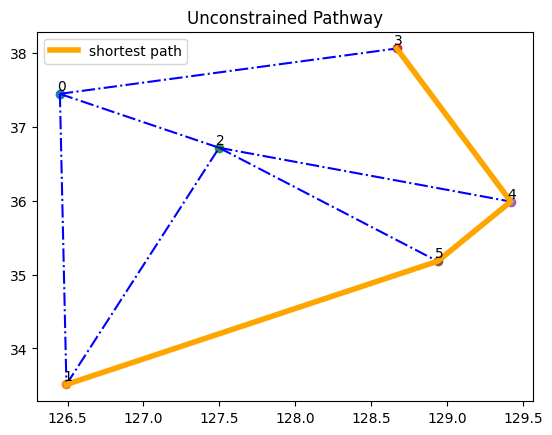

In [72]:
#polygon list
polygon = [(128.7, 36.6), (128.7, 37.6), (129.3, 37.6), (129.3, 36.6)]

#add the first element to the end for polygon plot
polygon = polygon + [polygon[0]]

for n1, n2 in zip(xi,xj):
    plt.plot([data.iloc[n1, -2],data.iloc[n2, -2]], [data.iloc[n1,-1],data.iloc[n2,-1]], '-.', c = 'blue')

x_shift = -0.02 #longitudinal shift of annotations
y_shift = 0.05 #latitudinal shift of annotations

#scatter plot of cities with annotations
for i in range(len(data.index)):
    x_coord = data.iloc[i, -2]
    y_coord = data.iloc[i, -1]
    plt.scatter(x_coord, y_coord)
    plt.annotate(i, (x_coord + x_shift, y_coord + y_shift))
    
#plt.plot([x for x,y in polygon], [y for x,y in polygon], '--', c = 'red', label = "polygon")

plt.plot(data.iloc[unconstrained_path, -2], data.iloc[unconstrained_path, -1], 
         linewidth = 4, color = 'orange', label = "shortest path")
plt.title("Unconstrained Pathway")
plt.legend()
plt.savefig("./images/Unconstrained_Pathway.png")
plt.show()

# Constrained Path Plot

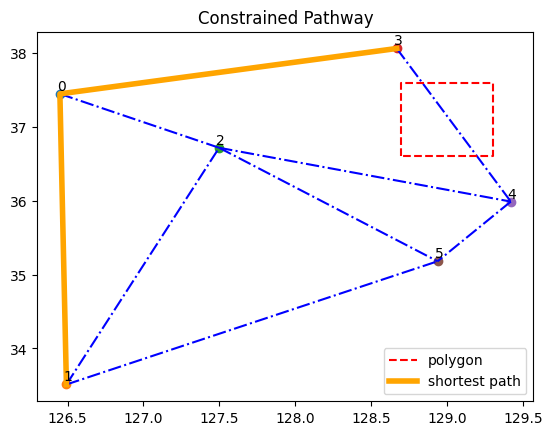

In [68]:
#polygon list
polygon = [(128.7, 36.6), (128.7, 37.6), (129.3, 37.6), (129.3, 36.6)]

#add the first element to the end for polygon plot
polygon = polygon + [polygon[0]]

for n1, n2 in zip(xi,xj):
    plt.plot([data.iloc[n1, -2],data.iloc[n2, -2]], [data.iloc[n1,-1],data.iloc[n2,-1]], '-.', c = 'blue')

x_shift = -0.02 #longitudinal shift of annotations
y_shift = 0.05 #latitudinal shift of annotations

#scatter plot of cities with annotations
for i in range(len(data.index)):
    x_coord = data.iloc[i, -2]
    y_coord = data.iloc[i, -1]
    plt.scatter(x_coord, y_coord)
    plt.annotate(i, (x_coord + x_shift, y_coord + y_shift))
    
plt.plot([x for x,y in polygon], [y for x,y in polygon], '--', c = 'red', label = "polygon")

plt.plot(data.iloc[constrained_path, -2], data.iloc[constrained_path, -1], 
         linewidth = 4, color = 'orange', label = "shortest path")
plt.title("Constrained Pathway")

plt.legend()
plt.savefig("./images/Constrained_Pathway.png")
plt.show()

# Reference

[1] (n.d.). How to find Shortest Paths from Source to all Vertices using Dijkstra’s Algorithm. GeeksForGeeks. Retrieved May 21, 2023, from https://www.geeksforgeeks.org/dijkstras-shortest-path-algorithm-greedy-algo-7/

[2] The Shapely User Manual — Shapely 2.0.1 documentation. (n.d.). https://shapely.readthedocs.io/en/stable/manual.html